Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Lastly, hit **Validate**.

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Vincent Chen"
COLLABORATORS = ""

---

# Lab 12: Baby-Weights

** This assignment is due 04/16/2018 at 11:59pm **

In this lab, we investigate the connection between smoking during pregnancy and infant health using the `babies` dataset—observations for 1236 live male births containing information on the mother’s pre-pregnancy health and fetal growth. Specifically, we have information on the mother’s age, weight, height, smoking status, and prior pregnancies, as well as the length of the pregnancy and infant’s birthweight.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Exploring & Cleaning the Data

In this part, we will examine the `babies` dataset and prepare it for model-fitting in Part 2. Most of the code has been provided for you.

First, run the cell below to load the `babies` dataset into a DataFrame called `babies`.

In [3]:
# load the data
babies = pd.read_csv('data/babies.data', sep = r'\s+')
babies.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,123,999,0,36,69,190,0
4,108,282,0,23,67,125,1


Look closely at the 'gestation' column above, which represents the length of the mother's pregnancy in days. Do any particular values stand out?

It turns out that some of the columns have entries '99' or '999' for data that is actually missing. To clear any confusion, run the cell below to replace all those missing entries with NaN values.

In [4]:
# replace various missingness codes with NA
# and categorical data with actual categories
babies.replace({"gestation": {999 : np.nan},
                "age"   : {99  : np.nan},
                "height": {99  : np.nan},
                "weight": {999 : np.nan},
                "smoke" : {0   : "non-smoker",
                           1   : "smoker",
                           9   : np.nan},
                "parity": {0   : "not first child",
                           1   : "first child"}}, 
               inplace = True)

babies.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284.0,not first child,27.0,62.0,100.0,non-smoker
1,113,282.0,not first child,33.0,64.0,135.0,non-smoker
2,128,279.0,not first child,28.0,64.0,115.0,smoker
3,123,NaN,not first child,36.0,69.0,190.0,non-smoker
4,108,282.0,not first child,23.0,67.0,125.0,smoker


Now that our data no longer has misleading values, let's visualize the data. Run the cell below to generate a violin plot, which compares the distributions of the babies' birth weights depending on four different categories. For each category, we split the dataset into 2 parts...

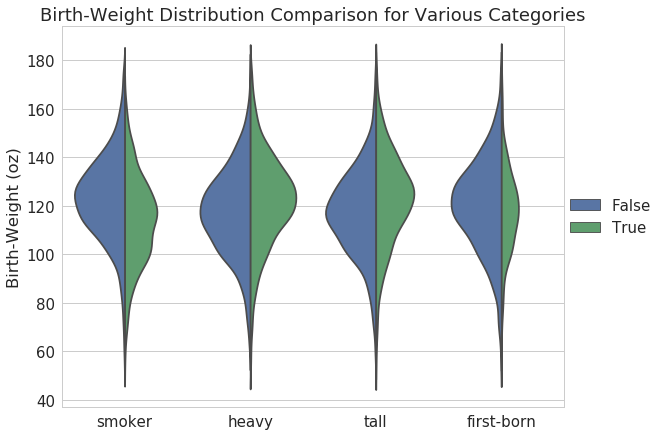

In [5]:
# divide mothers by their covariates
babies_by_category = babies \
.assign(smoker = (babies["smoke"] == "smoker"),
        heavy  = (babies["weight"] > babies["weight"].median()),
        tall   = (babies["height"] > babies["height"].median()),
        firstborn = (babies["parity"] == "first child")) \
.loc[:, ["bwt", "smoker", "heavy", "tall", "firstborn"]] \
.rename(columns = {"firstborn": "first-born",
                   "bwt" : "birth-weight"}) 

plt.figure(figsize = (9, 7))

# compare birthweight distributions for each category
sns.violinplot(x = "variable", 
               y = "birth-weight", 
               hue = "value", 
               data = babies_by_category.melt(["birth-weight"]).dropna(),
               split = True,    
               scale = "count", # scale each KDE by number of samples
               inner = None)

plt.title("Birth-Weight Distribution Comparison for Various Categories")
plt.xlabel("")
plt.ylabel("Birth-Weight (oz)")
plt.legend(title = "", loc = "right", bbox_to_anchor = (1.2, 0.5))
plt.show()

### Question 1

Pick a category above and write 1 sentence explaining the difference between the corresponding green (`category=True`) distribution and the blue (`category=False`) distribution. How do the distributions of baby birth weights differ based on whether or not the category is `True` or `False`?

If smoking is false, then the baby's weight is most frequently around 125, whereas if smoking is true, then the weight is instead 120 and right leaning.

## Part 2: Fitting a Linear Model

In this part, we will perform linear regression according to the model below in order to predict baby birth weights.

$$
\texttt{birth-weight}_i
= \beta_0^* 
+ \beta_\texttt{gestation}^*\cdot\texttt{gestation}_i
+ \beta_\texttt{smoke}^*\cdot\texttt{smoke}_i
+ \beta_\texttt{height}^*\cdot\texttt{height}_i
+ \beta_\texttt{weight}^*\cdot\texttt{weight}_i
+ \varepsilon_i
$$

To make the math easier and avoid any funky errors, run the cell below to drop all rows of `babies` with NaN values.

In [6]:
babies = babies.dropna()

### Question 2

Now, let's create a linear regression model to predict the babies' birth weights (`y`) given information about each baby's mother (`X`). 

#### Question 2a
First, let's create `X` below.
* `X` should contain columns 'gestation', 'smoke', 'height', and 'weight' from the `babies` data frame (**in that order**)
* Notice that in order to fit a linear model to `X`, all of our columns in `X` must be numeric. When dealing with the `smoke` column, replace all 'smoker' entries with a 1, and all 'non-smoker' entries with a 0

In [7]:
X = babies[['gestation', 'smoke', 'height', 'weight']].copy()
X.replace({"smoke": {"smoker": 1, "non-smoker": 0}},
         inplace = True)

In [8]:
assert len(X.columns) == 4

# if this fails, make sure X contains the correct columns following the order below
assert np.all(X.columns == ['gestation', 'smoke', 'height', 'weight'])

# if this fails, make sure there are no NaNs in your babies df
assert not np.any(X.isna())

assert np.all(np.unique(X['smoke'].values) == np.array([0, 1]))

#### Question 2b
In the cell below, create a variable `y` that contains the birth weights of the babies.

In [9]:
y = babies[['bwt']]

In [10]:
assert len(y) == len(X)
assert np.isclose(np.mean(y), 119.5, atol=1)

### Question 3

In the cell below, use sklearn to create a [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object named `model`. 

Then, fit your model to `X` and `y`. The print statement below will print all the $\beta$ coefficients of your model (from the equation above) after the model has been fit to your data.

In [11]:
X.shape #(1174,4)
y.shape #(1174)

(1174, 1)

In [12]:
from sklearn.linear_model import LinearRegression as lm

model = lm()
model.fit(X, y)

print("""
intercept: %.2f
gestation: %.2f
smoke:     %.2f
height:    %.2f
weight:    %.2f
""" % (tuple([model.intercept_]) + tuple(model.coef_[0])))



intercept: -77.26
gestation: 0.44
smoke:     -8.35
height:    1.10
weight:    0.06



In [13]:
assert np.isclose(model.intercept_, -77.2, atol=1)
assert np.isclose(model.coef_[0][1], -8.35, atol=0.1)

We see that smoking has a large negative coefficient, indicating that smoking has a negative association with birthweight even after controlling for the mother's height and weight. Obviously the estimated coefficient $\widehat\beta_{\texttt{smoke}}\neq 0$, but we are interested in whether the population regression coefficient $\beta_{\texttt{smoke}}^*\neq 0$, which is to say *whether smoking effects baby-weight* in the population (assuming the linear model). We don't have access to $\beta_{\texttt{smoke}}^*$ (it's a theoretical construct, not something we can measure). But we can use a **bootstrap confidence interval** to account for variability in the sample regression coefficient $\widehat\beta_{\texttt{smoke}}$.

## Part 3: Bootstrap

#### Bootstrap Sampling Distribution of $\widehat\beta_\texttt{smoke}$

Here we consider the pairs $(X_i, y_i)$ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
(X_i^*, y_i^*) 
= (X_I, y_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
$$

Run the cell below to define the functions `simple_resample` and `bootstrap`, which will help you in the next question.

In [14]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

### Question 4

Implement the `smoke_coeff` function below. This function will be our statistic, which will be called on several bootstrap resamples of our data.

Since we are trying to examine the distribution of possible values for $\widehat\beta_\texttt{smoke}$, the function should:
* Fit a model to a new `X` and `y` (created from a bootstrap resample named `babies_array`) provided below
* Return the coefficient of the model corresponding to $\widehat\beta_\texttt{smoke}$ (should be the second coefficient of the model)

Keep in mind that this cell may take some time to run as it computes the statistic `smoke_coeff` on several thousand bootstrap resamples of the data.

In [15]:
def smoke_coeff(babies_array):
    X = babies_array[:, 1:]
    y = babies_array[:, 0]
    
    y = pd.Series(y).to_frame()

    model = lm()
    model.fit(X,y)
    beta_smoke = model.coef_[0][1]

    return beta_smoke

babies_array = babies\
.loc[:, ["bwt", "gestation", "smoke", "height", "weight"]]\
.replace({"smoke" : {"non-smoker":0, "smoker":1}}).values

beta_hat_sampling = bootstrap(babies_array, smoke_coeff)

In [16]:
assert np.isclose(np.mean(beta_hat_sampling), -8.345, atol=0.1)
assert np.isclose(np.std(beta_hat_sampling), 0.948, atol=0.1)

Run the cell below to plot the bootstrap sampling distribution of all of the $\widehat\beta_\texttt{smoke}$ values.

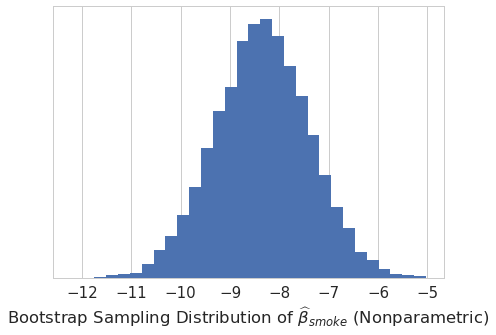

In [17]:
plt.figure(figsize = (7, 5))
plt.hist(beta_hat_sampling, bins = 30)
plt.xlabel("Bootstrap Sampling Distribution of $\\widehat{\\beta}_{smoke}$ (Nonparametric)")
plt.yticks([])
plt.show()

### Question 5

Use the [percentile](https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) method to construct a $95\%$ confidence interval for $\beta_{\texttt{smoke}}^*$ based on the bootstrap sampling distribution. If the confidence interval **does not include 0**, we reject the null hypothesis $H_0 : \beta_{\texttt{smoke}}^* = 0$.



In [18]:
left_confidence_interval_endpoint = np.percentile(beta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(beta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(-10.250704111458884, -6.4700478815494025)

In [19]:
assert np.isclose(left_confidence_interval_endpoint, -10.20, atol=0.1)
assert np.isclose(right_confidence_interval_endpoint, -6.46, atol=0.1)

---
### Submission
You have completed the assignment! Please do not forget to submit before 11:59pm. Feel free to read ahead for bonus material concerning the bootstrap and hypothesis testing.

---

#### Bonus Material: Semiparametric Bootstrap Sampling Distribution of $\widehat\beta_\texttt{smoke}$

Now we consider the *residuals* $e_i := y_i - X_i\widehat\beta $ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
(X_i^*, y_i^*) 
= (X_i, X_i\widehat\beta + e_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
$$

In [20]:
y_hat = model.predict(X)
residuals = (y - y_hat).values

def smoke_coeff_semi(e, X = X, y_hat = y_hat):
    y_new = y_hat + e
    
    model_new = lm().fit(X, y_new)
    return(model_new.coef_[0, 1])


beta_hat_sampling_semi = bootstrap(residuals, smoke_coeff_semi)

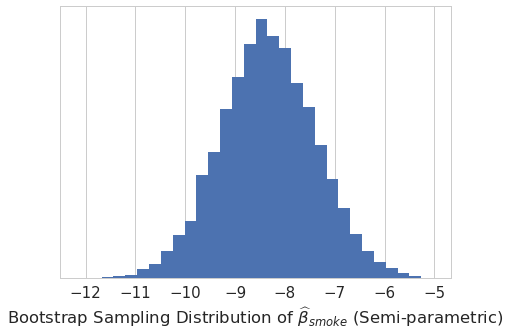

In [21]:
plt.figure(figsize = (7, 5))
plt.hist(beta_hat_sampling_semi, bins = 30)
plt.xlabel("Bootstrap Sampling Distribution of $\\widehat{\\beta}_{smoke}$ (Semi-parametric)")
plt.yticks([])
plt.show()

#### Bonus Material: Permutation Test 

One way to test the hypothesis that smoking "doesn't matter" in the model is with a **permutation $F$-test**. First, fit the linear model above (model 1), and then fit a model where we force $\beta_\texttt{smoke} = 0$ (model 2). The two models have residual-sum-of-squares $\text{RSS}_1$ and $\text{RSS}_2$, respectively. Necessarily $\text{RSS}_1 \le \text{RSS}_2$, since the first model has more free parameters. We can consider the relative improvement of including $\beta_{\texttt{smoke}}$ 

$$
F = \frac{\text{RSS}_2 - \text{RSS}_1}{\text{RSS}_1},
$$

so a permutation test permutes the $\texttt{smoke}$ labels and compares the observed $F$ statistic to the permutation distribution.

In [22]:
from sklearn.metrics import mean_squared_error

# RSS2 is same regardless of smoking labels
X_sub = babies.loc[:, ["gestation", "height", "weight"]]
sub_model = lm().fit(X_sub, y)
RSS2 = mean_squared_error(y, sub_model.predict(X_sub))

RSS1_obs = mean_squared_error(y, model.predict(X))
F_obs = (RSS2 - RSS1_obs) / RSS1_obs

n = len(babies_array)
F = []
for _ in range(10000):
    X_perm = babies_array[:, 1:]
    X_perm[:, 1] = X_perm[np.random.permutation(n), 1]
    
    perm_model = lm().fit(X_perm, y)
    RSS1 = mean_squared_error(y, perm_model.predict(X_perm))
    
    F.append((RSS2 - RSS1) / RSS1)



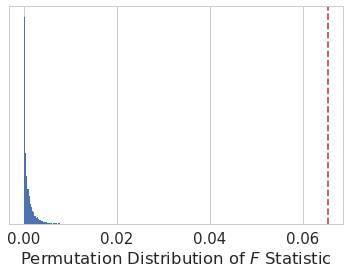

In [23]:
plt.hist(F, bins = 50)
plt.axvline(x = F_obs, color = 'r', ls = '--')
plt.yticks([])
plt.xlabel('Permutation Distribution of $F$ Statistic')
plt.show()